# Titanic - Machine Learning from Disaster


This data science challenge and corresponding data are found on Kaggle: https://www.kaggle.com/c/titanic/overview 

Here, I'll predict survival on the Titanic. The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

Let's fetch the data and load it:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preprocessing: 
These data have already been split into a training and test set. I'll be training the best model I can determine using the training data, and then make predictions on the test data.

In [6]:
TITANIC_train = pd.read_csv('train.csv')
TITANIC_test = pd.read_csv('test.csv')

Taking a look at the training set:

In [7]:
TITANIC_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Most of these data are self-explanatory, but a few are interesting. 

* **Pclass**: passenger class
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic
* **Parch**: how many children & parents of the passenger aboard the Titanic
* **Embarked**: Where the passenger embarked on the Titanic

Get more info on the dataset:

In [8]:
TITANIC_train.shape

(891, 12)

In [9]:
TITANIC_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


How many missing values are present across each variable?

In [10]:
TITANIC_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Okay good to know! 177 missing values in the age category, and 687 in the cabin category. 

I'm now going to take a look at the categorical attributes:

In [11]:
TITANIC_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [12]:
TITANIC_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [13]:
TITANIC_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

C = Cherbourg, Q = Queenstown, S = Southampton

### Building some Pipelines now to make preprocessing easy: 

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder #to handle categorical attributes
from sklearn.preprocessing import StandardScaler # to handle missing values in numerical attributes

To handle missing values for numerical attributes:

In [15]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

To encode categorical attributes:

In [16]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

Join the numerical and categorical pipelines:

In [17]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Now creating a new variable where I use the pipeline and transform the training dataset:

In [18]:
X_train = preprocess_pipeline.fit_transform(
    TITANIC_train[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

#### Dependent/Predicted Variable:

In [19]:
y_train = TITANIC_train["Survived"]

I'm going to try a few different models here. **Linear Regression**, **Logistic Regression**, **Decision Tree**, **Random Forest**, and **SVC**. 

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [22]:
Linear_model = LinearRegression()

# fit the model on the training data
Linear_model.fit(X_train, y_train)

LinearRegression()

The model is now trained. Let's use it to make predictions on the test set. First, the test set needs to go through the same preprocessing pipeline. 

In [23]:
X_test = preprocess_pipeline.fit_transform(
    TITANIC_test[num_attribs + cat_attribs])

And now make predictions:

In [24]:
y_pred = Linear_model.predict(X_test)

Use cross-validation to see how good the model is:

In [25]:
from sklearn.model_selection import cross_val_score

Linear_scores = cross_val_score(Linear_model, X_train, y_train, cv=10)
Linear_scores.mean()

0.3625102333415447

36% isn't the best. Let's see if some of the other models do better! Moving on to **Logistic Regression** now: 

In [26]:
Log_model = LogisticRegression()

# fit the model on the training data
Log_model.fit(X_train, y_train)

LogisticRegression()

The test set has already gone through the preprocessing pipeline now. So now I'll go ahead and make predictions with the model:

In [31]:
y_pred = Log_model.predict(X_test)

In [32]:
Log_scores = cross_val_score(Log_model, X_train, y_train, cv=10)
Log_scores.mean()

0.7991260923845193

Close to 80% is way better than the Linear Model! Cool. Now I would like to try the Decision Tree:

In [35]:
tree_reg = DecisionTreeRegressor()

# fit the model on the training data
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

Use model to predict on the test set:

In [39]:
y_pred = tree_reg.predict(X_test)

Determine cross validation score of the decision tree regressor:

In [38]:
tree_scores = cross_val_score(tree_reg, X_train, y_train, cv=10)
tree_scores.mean()

0.0766228335863442

Ouch, at 8% the tree is literally worse than a linear regression model. I'm now going to try the **Random Forest**

In [40]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model on the training data
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
forest_scores = cross_val_score(forest, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

Random Forest is so far the best at nearly 81% accuracy. Trying the last method now, **support vector machines**:

In [42]:
SVM_model = SVC()

# Rather than fitting the model, I'm going to go ahead and determine its cross-validation score:
SVM_scores = cross_val_score(SVM_model, X_train, y_train, cv=10)
SVM_scores.mean()

0.8249438202247191

SVM is the best of all at 83%! I'd like to visualize the accuracy of all models further: 

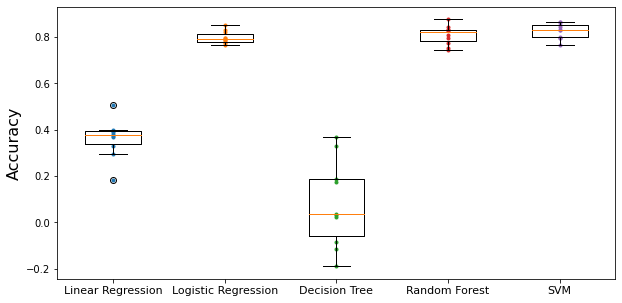

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot([1]*10,Linear_scores, ".")
plt.plot([2]*10,Log_scores, ".")
plt.plot([3]*10, tree_scores, ".")
plt.plot([4]*10, forest_scores, ".")
plt.plot([5]*10, SVM_scores, ".")

plt.boxplot([Linear_scores, Log_scores,tree_scores, forest_scores,SVM_scores], labels=("Linear Regression", "Logistic Regression", "Decision Tree", "Random Forest", "SVM"))
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize= 11 )
plt.show()

# SVM Classifer looks the best at predicting survival